## Imports + utility functions

In [1]:
import re
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pyproj
from shapely.ops import transform
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pystac_client import Client
import stackstac

In [2]:
def get_bbox(shp_fp):
    gdf = gpd.read_file(shp_fp)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple(gdf.total_bounds)

    return bbox


def read_cog_from_bbox(cog_url, bbox=None):
    with rxr.open_rasterio(cog_url) as rds:
        # Reproject bounding box to match raster CRS
        if bbox is None:
            out_cog = rds.copy()
        else:
            bbox_geom = box(*bbox)
            cog_epsg = rds.rio.crs.to_epsg()
        
            project = pyproj.Transformer.from_proj(
                pyproj.Proj('epsg:4326'),  # hard-coded in get_bbox() function 
                pyproj.Proj(f'epsg:{cog_epsg}'),
                always_xy = True) 
            
            # Clip COG to reprojected bounds if provided and return
            bbox_geom_proj = transform(project.transform, bbox_geom)
            out_cog = rds.rio.clip_box(*bbox_geom_proj.bounds)
    
    return out_cog

def get_utm_epsg(stac_item):
    """Returns WGS/UTM zone in EPSG format for a STAC item"""
    # Get centroid of item extent geometry from properties
    polygon = Polygon(stac_item.geometry['coordinates'][0])
    centroid = polygon.centroid
    
    # Calculate zone based on coords and return
    utm_zone = int((centroid.x + 180) // 6) + 1
    if centroid.y > 0:
        utm_epsg = int(f'{326}{utm_zone}')
    else:
        utm_epsg = int(f'{327}{utm_zone}')
    
    return utm_epsg

## Accessing Data from STAC

In [3]:
# Define spatial filter and date range for API query
# GeoJSON sourced from https://opendata.thunderbay.ca/datasets/eb91862c4d064944b7550b3fee2066e4_0/explore
tb_shp_fp = './thunder_bay_urban_area.geojson'
tb_aoi_gdf = gpd.read_file(tb_shp_fp)
tb_bbox = get_bbox(tb_shp_fp)

start_date = '2025-01-01'
end_date = '2025-12-31'

In [4]:
# List all RCM-CARD items in collection satisfying search criteria
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
search = catalog.search(
    collections=['rcm-ard'],
    bbox=tb_bbox,
    datetime=f'{start_date}/{end_date}'
)

items = search.item_collection()
print(f'{len(items)} products found')

1 products found


### Reading data from the STAC in native CRS

In [5]:
# All RCM-CARD products are stored in their respective WGS/UTM projection
item_tb = items[0]
utm_crs = get_utm_epsg(item_tb)
print(f'RCM-CARD scene is originally projected in EPSG:{utm_crs}')

RCM-CARD scene is originally projected in EPSG:32616


In [6]:
# Get native pixel resolution from SAR beam mode in item properties
resolution =  int(re.findall(r'\d+', item_tb.properties['sar:instrument_mode'])[0])
print(f'STAC raster assets have a {resolution}m pixel resolution')

STAC raster assets have a 30m pixel resolution


In [7]:
# Stack selected assets into rioxarray dataset
asset_list = ['RL', 'RR', 'dataMask']
stack_tb = stackstac.stack(item_tb,
                            assets=asset_list,
                            bounds_latlon=tb_bbox,  # only loading pixels within our bounding box
                            resolution=resolution,
                            epsg=utm_crs
                           )
stack_tb.attrs['long_name'] = asset_list
print(f'All raster assets are projected in their native {stack_tb.rio.crs} with a {stack_tb.rio.resolution()[0]}m resolution')

All raster assets are projected in their native EPSG:32616 with a 30.0m resolution


<Axes: title={'center': 'time = 2025-02-01T12:15:24.159250, id = 0a379e6...'}, xlabel='x', ylabel='y'>

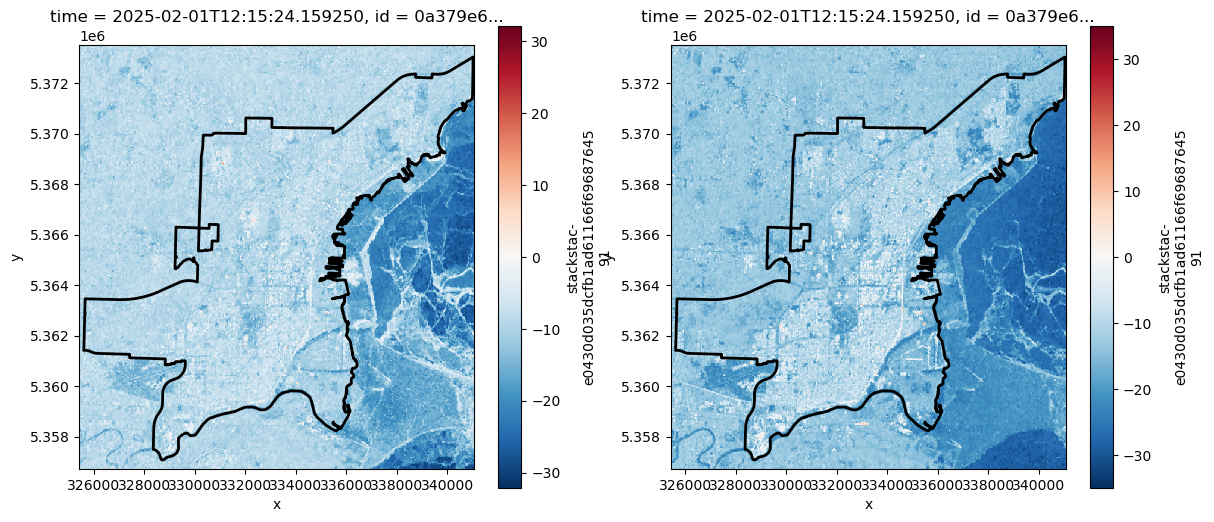

In [8]:
# Convert RL/RL assets to DB and plot alongside each other
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
rl_db_utm = 10 * np.log10(stack_tb.sel(band='RL'))
rl_db_utm.plot(ax=axes[0])
tb_aoi_gdf.to_crs(utm_crs).plot(facecolor='none', edgecolor='black', linewidth=2, ax=axes[0])

rr_db_utm = 10 * np.log10(stack_tb.sel(band='RR'))
rr_db_utm.plot(ax=axes[1])
tb_aoi_gdf.to_crs(utm_crs).plot(facecolor='none', edgecolor='black', linewidth=2, ax=axes[1])

### Reading data from STAC using an alternative CRS

Government of Canada Open Data is often provided in Lambert Conformal Conic (EPSG:3979).

We can transform raster coordinates on-the-fly to match this when reading from the STAC catalog

In [9]:
# New example using RCM scenes over Baffin Island in the far north of Canada
# Boundary sourced from https://ostrnrcan-dostrncan.canada.ca/entities/publication/27a915c8-1241-4af5-a146-b42502ae4ad9
# https://cgs-pals.ca/downloads/gis/
baffin_shp_fp = './baffin_island_example.geojson'
baffin_aoi_gdf = gpd.read_file(baffin_shp_fp)
baffin_bbox = get_bbox(baffin_shp_fp)

search = catalog.search(
    collections=['rcm-ard'],
    bbox=baffin_bbox,
    datetime=f'{start_date}/{end_date}'
)

items = search.item_collection()
item_baffin = items[0]

In [10]:
# %%time
# We now read the full RCM scene into an array instead of just a subset
lcc_crs = 3979
stack_baffin = stackstac.stack(item_baffin,
                               assets=asset_list,
                               bounds_latlon=baffin_bbox,  # only include pixels within our bounding box
                               resolution=resolution,
                               epsg=lcc_crs
                              )
stack_baffin.attrs['long_name'] = asset_list
print(f'Successfully read RCM-CARD data into array using {stack_baffin.rio.crs} on-the-fly with stackstac!')

Successfully read RCM-CARD data into array using EPSG:3979 on-the-fly with stackstac!


### Reprojecting stacked xarray data

We can also read the data from our STAC catalog into its native CRS, then reproject into another to create a separate array

In [11]:
# Using same Baffin Island AOI, read data into array using its native WGS/UTM projection
baffin_utm_crs = get_utm_epsg(item_baffin)
stack_baffin_utm = stackstac.stack(item_baffin,
                                   assets=asset_list,
                                   bounds_latlon=baffin_bbox,  # only include pixels within our bounding box
                                   resolution=resolution,
                                   epsg=baffin_utm_crs
                                  )
stack_baffin_utm.attrs['long_name'] = asset_list
print(f'Loaded item {item_baffin.properties["order_key"]} using natve CRS {stack_baffin_utm.rio.crs}')

Loaded item RCM3_OK3308027_PK3469453_1_SC30MCPA_20250201_110650_CH_CV_MLC using natve CRS EPSG:32620


In [12]:
# Reproject the dataset into EPSG:3979 (lambert Conformal Conic)
stack_baffin_reproj = stack_baffin_utm[0, :, :, :].rio.reproject(3979)  # drop redundant time dimension first
print(f'Reprojected from {stack_baffin_utm.rio.crs} to {stack_baffin_reproj.rio.crs}!')

Reprojected from EPSG:32620 to EPSG:3979!


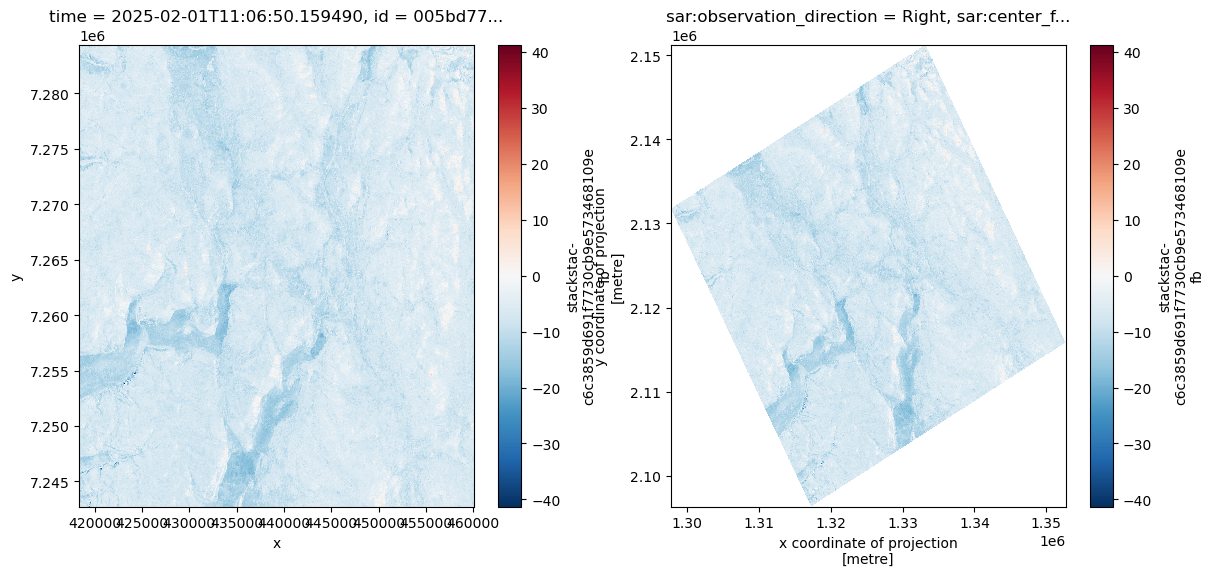

In [13]:
# Comparing projections side-by-side:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
rl_db_utm = 10 * np.log10(stack_baffin_utm.sel(band='RL'))
rl_db_utm.plot(ax=axes[0])

rl_db_3979 = 10 * np.log10(stack_baffin_reproj.sel(band='RL'))
rl_db_3979.plot(ax=axes[1])